# Personal Protective Equipment Detection using Amazon Rekognition

***
This notebook provides a walkthrough of [PPE Detection API](https://docs.aws.amazon.com/rekognition/latest/dg/ppe-detection.html) in Amazon Rekognition to detect Personal Protective Equipment (PPE) worn by persons.
***

# Initialize stuff

In [2]:
# Install necessary packages
!pip install opencv-python-headless

Keyring is skipped due to an exception: 'keyring.backends'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 MB 21.4 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip


In [6]:
# Initialise Notebook
import boto3
from IPython.display import HTML, display, Image as IImage
from PIL import Image, ImageDraw, ExifTags, ImageColor
import json
import cv2
import math
import os
import io

In [7]:
# Curent AWS Region. Use this to choose corresponding S3 bucket with sample content

mySession = boto3.session.Session()
awsRegion = mySession.region_name

In [8]:
# Init clients
rekognition = boto3.client('rekognition')
s3 = boto3.client('s3')

In [9]:
# S3 bucket that contains sample images and videos

# We are providing sample images and videos in this bucket so
# you do not have to manually download/upload test images and videos.

bucketName = "aws-rek-immersionday-" + awsRegion

In [10]:
# Create temporary directory
# This directory is not needed to call Rekognition APIs.
# We will only use this directory to download images from S3 bucket and draw bounding boxes

!mkdir m1tmp
tempFolder = 'm1tmp/'

# Detect Persons wearing PPEs in image
***

In [11]:
imageName = "media/ppe-detection/ppe-image-group.jpg"
#imageName = "media/ppe-detection/ppe-image-single.jpg"

In [12]:
display(IImage(url=s3.generate_presigned_url('get_object', Params={'Bucket': bucketName, 'Key': imageName})))

#### Call Rekognition to detect persons and PPE

In [13]:
# Call Amazon Rekognition to detect PPE in the image
# https://docs.aws.amazon.com/rekognition/latest/dg/API_DetectProtectiveEquipment.html
detectPPEResponse = rekognition.detect_protective_equipment(
        Image={
            'S3Object': {
                'Bucket': bucketName,
                'Name': imageName
            }
        },
        SummarizationAttributes={
            'MinConfidence': 90,
            'RequiredEquipmentTypes': [
                'FACE_COVER',
                'HEAD_COVER',
                'HAND_COVER', #you can remove required equipment type from the list based on your requirements
            ]
        }
    )

# print(detectPPEResponse)

#### Review the raw JSON reponse from Rekognition

In [14]:
# Show JSON response returned by Rekognition PPE Detection API
# In the JSON response below, you will see detected body parts, confidence score and additional information.

display(detectPPEResponse)

{'ProtectiveEquipmentModelVersion': '1.0',
 'Persons': [{'BodyParts': [{'Name': 'FACE',
     'Confidence': 99.07738494873047,
     'EquipmentDetections': [{'BoundingBox': {'Width': 0.06805413216352463,
        'Height': 0.09381836652755737,
        'Left': 0.7537466287612915,
        'Top': 0.26088595390319824},
       'Confidence': 99.98419189453125,
       'Type': 'FACE_COVER',
       'CoversBodyPart': {'Confidence': 99.76295471191406, 'Value': True}}]},
    {'Name': 'LEFT_HAND',
     'Confidence': 99.25702667236328,
     'EquipmentDetections': []},
    {'Name': 'RIGHT_HAND',
     'Confidence': 80.11490631103516,
     'EquipmentDetections': []},
    {'Name': 'HEAD',
     'Confidence': 99.9693374633789,
     'EquipmentDetections': [{'BoundingBox': {'Width': 0.09358207136392593,
        'Height': 0.10753925144672394,
        'Left': 0.7455776929855347,
        'Top': 0.16204142570495605},
       'Confidence': 98.4826889038086,
       'Type': 'HEAD_COVER',
       'CoversBodyPart': {'Con

#### Call Rekognition to detect persons and PPE

In [15]:
# Call Amazon Rekognition to detect PPE in the image
# https://docs.aws.amazon.com/rekognition/latest/dg/API_DetectProtectiveEquipment.html
detectPPEResponse = rekognition.detect_protective_equipment(
        Image={
            'S3Object': {
                'Bucket': bucketName,
                'Name': imageName
            }
        },
        SummarizationAttributes={
            'MinConfidence': 90,
            'RequiredEquipmentTypes': [
                'FACE_COVER',
                'HEAD_COVER',
                #'HAND_COVER', #only detecting face and head cover
            ]
        }
    )

# print(detectPPEResponse)

#### Review the raw JSON reponse from Rekognition

In [16]:
# Show JSON response returned by Rekognition PPE Detection API
# As we changed the required equipment type list above, 
# you will see that Rekognition detected that all persons in the image are wearing required PPEs

display(detectPPEResponse)

{'ProtectiveEquipmentModelVersion': '1.0',
 'Persons': [{'BodyParts': [{'Name': 'FACE',
     'Confidence': 99.07738494873047,
     'EquipmentDetections': [{'BoundingBox': {'Width': 0.06805413216352463,
        'Height': 0.09381836652755737,
        'Left': 0.7537466287612915,
        'Top': 0.26088595390319824},
       'Confidence': 99.98419189453125,
       'Type': 'FACE_COVER',
       'CoversBodyPart': {'Confidence': 99.76295471191406, 'Value': True}}]},
    {'Name': 'LEFT_HAND',
     'Confidence': 99.25702667236328,
     'EquipmentDetections': []},
    {'Name': 'RIGHT_HAND',
     'Confidence': 80.11490631103516,
     'EquipmentDetections': []},
    {'Name': 'HEAD',
     'Confidence': 99.9693374633789,
     'EquipmentDetections': [{'BoundingBox': {'Width': 0.09358207136392593,
        'Height': 0.10753925144672394,
        'Left': 0.7455776929855347,
        'Top': 0.16204142570495605},
       'Confidence': 98.4826889038086,
       'Type': 'HEAD_COVER',
       'CoversBodyPart': {'Con

#### Drawing bounding boxes around PPE

In [17]:
# it will draw green bounding box if specific PPE is found
# it will draw warning yellow bounding box within face mask bounding box if confidence is lower than supplied value
# if specific PPE (such as hand cover, face cover etc.) is not found, it will draw red bounding box around body/person

def detect_ppe(sourceImage, confidence):

    fill_green='#00d400'
    fill_red='#ff0000'
    fill_yellow='#ffff00'
    line_width=3
    
    imageLocation = tempFolder+os.path.basename(sourceImage)
    s3.download_file(bucketName, sourceImage, imageLocation)

    # open image and get image data from stream.
    image = Image.open(open(imageLocation,'rb'))
    stream = io.BytesIO()
    image.save(stream, format=image.format)    
    image_binary = stream.getvalue()
    imgWidth, imgHeight = image.size  
    draw = ImageDraw.Draw(image)  
    

    for person in detectPPEResponse['Persons']:
        
        found_mask=False

        for body_part in person['BodyParts']:
            ppe_items = body_part['EquipmentDetections']
                 
            for ppe_item in ppe_items:
                # found a mask
                if ppe_item['Type'] == 'FACE_COVER': # you can change it to "HEAD_COVER" or "HAND_COVER"
                    fill_color=fill_green
                    found_mask=True
                    # check if mask covers face
                    if ppe_item['CoversBodyPart']['Value'] == False:
                        fill_color=fill='#ff0000'
                    # draw bounding box around mask
                    box = ppe_item['BoundingBox']
                    left = imgWidth * box['Left']
                    top = imgHeight * box['Top']
                    width = imgWidth * box['Width']
                    height = imgHeight * box['Height']
                    points = (
                            (left,top),
                            (left + width, top),
                            (left + width, top + height),
                            (left , top + height),
                            (left, top)
                        )
                    draw.line(points, fill=fill_color, width=line_width)

                     # Check if confidence is lower than supplied value       
                    if ppe_item['CoversBodyPart']['Confidence'] < confidence:
                        # draw warning yellow bounding box within face mask bounding box
                        offset=line_width+ line_width 
                        points = (
                                    (left+offset,top + offset),
                                    (left + width-offset, top+offset),
                                    ((left) + (width-offset), (top-offset) + (height)),
                                    (left+ offset , (top) + (height -offset)),
                                    (left + offset, top + offset)
                                )
                        draw.line(points, fill=fill_yellow, width=line_width)
                
        if found_mask==False:
            # no face mask found so draw red bounding box around body
            box = person['BoundingBox']
            left = imgWidth * box['Left']
            top = imgHeight * box['Top']
            width = imgWidth * box['Width']
            height = imgHeight * box['Height']
            points = (
                (left,top),
                (left + width, top),
                (left + width, top + height),
                (left , top + height),
                (left, top)
                )
            draw.line(points, fill=fill_red, width=line_width)

    display(image)

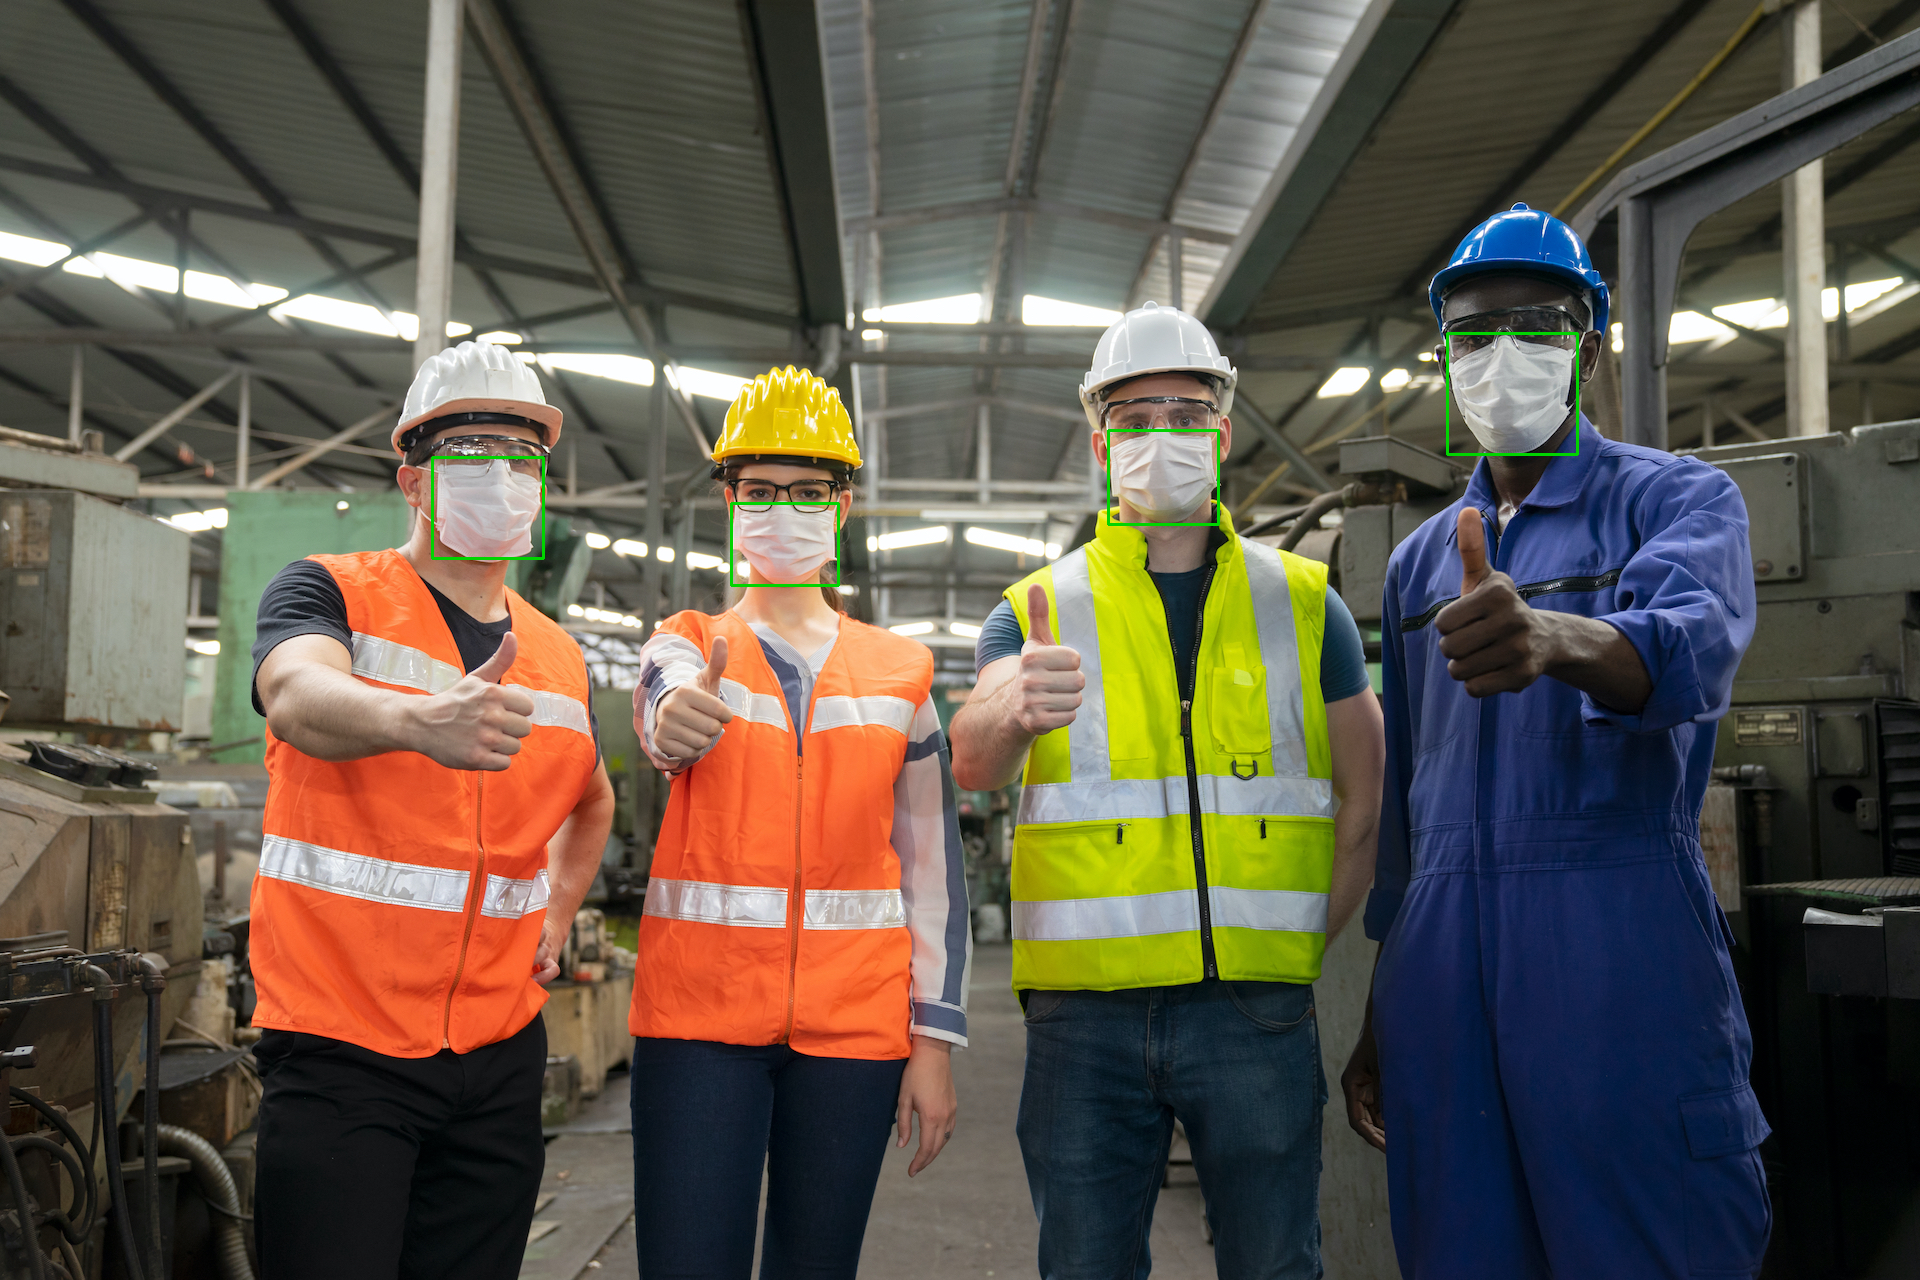

In [18]:
confidence=80 # confidence if the bodypart is covered by the particular PPE 
detect_ppe(imageName, confidence)

# Recognize persons wearing PPEs in video

- First we sample our video into individual image frames.
- We can then call `detect_protective_equipment` to detect persons wearing PPEs in the image frame
***

In [19]:
videoName = "media/ppe-detection/ppe-video.mov"
videoFile = tempFolder + "ppe-video.mov"

s3.download_file(bucketName, videoName, videoFile)

#### Call Rekognition to start a job for object detection

In [20]:
# Start video label recognition job
ppeLabels = []    
cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5) # frame rate
while(cap.isOpened()):
    frameId = cap.get(1) # current frame number
    print("Processing frame id: {}".format(frameId))
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        hasFrame, imageBytes = cv2.imencode(".jpg", frame)

        if(hasFrame):
            response = rekognition. detect_protective_equipment(
                Image={
                    'Bytes': imageBytes.tobytes(),
                }
            )
        
        for person in response["Persons"]:
            person["Timestamp"] = (frameId/frameRate)*1000
            ppeLabels.append(person)

Processing frame id: 0.0
Processing frame id: 1.0
Processing frame id: 2.0
Processing frame id: 3.0
Processing frame id: 4.0
Processing frame id: 5.0
Processing frame id: 6.0
Processing frame id: 7.0
Processing frame id: 8.0
Processing frame id: 9.0
Processing frame id: 10.0
Processing frame id: 11.0
Processing frame id: 12.0
Processing frame id: 13.0
Processing frame id: 14.0
Processing frame id: 15.0
Processing frame id: 16.0
Processing frame id: 17.0
Processing frame id: 18.0
Processing frame id: 19.0
Processing frame id: 20.0
Processing frame id: 21.0
Processing frame id: 22.0
Processing frame id: 23.0
Processing frame id: 24.0
Processing frame id: 25.0
Processing frame id: 26.0
Processing frame id: 27.0
Processing frame id: 28.0
Processing frame id: 29.0
Processing frame id: 30.0
Processing frame id: 31.0
Processing frame id: 32.0
Processing frame id: 33.0
Processing frame id: 34.0
Processing frame id: 35.0
Processing frame id: 36.0
Processing frame id: 37.0
Processing frame id: 3

#### Show video in the player

In [21]:
# Show video in a player

s3VideoUrl = s3.generate_presigned_url('get_object', Params={'Bucket': bucketName, 'Key': videoName})

videoTag = "<video controls='controls' autoplay width='640' height='360' name='Video' src='{0}'></video>".format(s3VideoUrl)

videoui = "<table><tr><td style='vertical-align: top'>{}</td></tr></table>".format(videoTag)

display(HTML(videoui))

#### Review raw JSON reponse from Rekognition

In [22]:
# Show JSON response returned by Rekognition PPE Detection API
# In the JSON response below, you will see list of detected body parts and timestamp.
# For each detected body part, you will see information like name of the body part and confidence
# If PPE is detected, it will provide confidence if the body part is covered and bounding box

display(ppeLabels)

[{'BodyParts': [{'Name': 'FACE',
    'Confidence': 99.37361145019531,
    'EquipmentDetections': [{'BoundingBox': {'Width': 0.06449034810066223,
       'Height': 0.09375998377799988,
       'Left': 0.736709713935852,
       'Top': 0.2604105472564697},
      'Confidence': 99.97423553466797,
      'Type': 'FACE_COVER',
      'CoversBodyPart': {'Confidence': 99.65497589111328, 'Value': True}}]},
   {'Name': 'LEFT_HAND',
    'Confidence': 99.32172393798828,
    'EquipmentDetections': []},
   {'Name': 'RIGHT_HAND',
    'Confidence': 88.27011108398438,
    'EquipmentDetections': []},
   {'Name': 'HEAD',
    'Confidence': 99.9615249633789,
    'EquipmentDetections': [{'BoundingBox': {'Width': 0.08751991391181946,
       'Height': 0.1122160479426384,
       'Left': 0.7300025820732117,
       'Top': 0.16121704876422882},
      'Confidence': 97.60816955566406,
      'Type': 'HEAD_COVER',
      'CoversBodyPart': {'Confidence': 99.98554229736328, 'Value': True}}]}],
  'BoundingBox': {'Width': 0.20

#### Export the results

In [23]:
with open(videoFile + ".json", "w") as f:
    f.write(json.dumps(ppeLabels)) 

cap.release()

# Recognize persons wearing PPEs in a live stream
***

In [26]:
# This is a sample code to detect PPE in a live stream. 
# Before you run this code, you would need to set up an RTSP stream on a publicly accessible IP.


"""
import cv2
import boto3
import time
from datetime import datetime
import json

def processFrame(videoStreamUrl):
    cap = cv2.VideoCapture(videoStreamUrl)
    ret, frame = cap.read()
    if ret:
        hasFrame, imageBytes = cv2.imencode(".jpg", frame)
        if hasFrame:
            session = boto3.session.Session()
            rekognition = session.client('rekognition')
            response = rekognition. detect_protective_equipment(
                    Image={
                        'Bytes': imageBytes.tobytes(),
                    }
                )
            print(response)
    cap.release()

# Video stream
videoStreamUrl = "rtsp://@202.65.69.68" # change this to your RTSP stream location
frameCaptureThreshold = 300

while (True):
    try:
        processFrame(videoStreamUrl)
    except Exception as e:
        print("Error: {}.".format(e))

    time.sleep(frameCaptureThreshold)

"""

'\nimport cv2\nimport boto3\nimport time\nfrom datetime import datetime\nimport json\n\ndef processFrame(videoStreamUrl):\n    cap = cv2.VideoCapture(videoStreamUrl)\n    ret, frame = cap.read()\n    if ret:\n        hasFrame, imageBytes = cv2.imencode(".jpg", frame)\n        if hasFrame:\n            session = boto3.session.Session()\n            rekognition = session.client(\'rekognition\')\n            response = rekognition. detect_protective_equipment(\n                    Image={\n                        \'Bytes\': imageBytes.tobytes(),\n                    }\n                )\n            print(response)\n    cap.release()\n\n# Video stream\nvideoStreamUrl = "rtsp://@202.65.69.68" # change this to your RTSP stream location\nframeCaptureThreshold = 300\n\nwhile (True):\n    try:\n        processFrame(videoStreamUrl)\n    except Exception as e:\n        print("Error: {}.".format(e))\n\n    time.sleep(frameCaptureThreshold)\n\n'

***
### References
- https://docs.aws.amazon.com/rekognition/latest/dg/API_DetectProtectiveEquipment.html
- https://docs.aws.amazon.com/rekognition/latest/dg/ppe-request-response.html

***

You have successfully used Amazon Rekognition to identify personal protective equipment in images and videos.